# Libraries

In [17]:
# laod required packages
import sys                          # for installing package
import os                           # for os related functions
import numpy as np                  # for dealing with numpy array
import pandas as pd                 # for dealing with dataframe
import matplotlib.pyplot as plt     # for plotting
%matplotlib inline
import nibabel as nib               # for dealing with fMRI data
from numpy.linalg import inv        # for inv()
%matplotlib inline
from scipy import stats             # for stats function e.g. to find p-value
import nilearn
from nilearn import plotting        # for plotting brain map
import math                         # for math function, checking NaN 
import sklearn as sk
import warnings
warnings.filterwarnings('ignore')

In [18]:
# install nistats package
# !{sys.executable} -m pip install nistats
import nistats

C:\Users\nasri\AppData\Local\Temp\ipykernel_11768\1587622113.py:3: UserWarning: 

 | Using Nistats with Nilearn versions >= 0.7.0 is redundant and potentially conflicting.
 | Nilearn versions 0.7.0 and up offer all the functionality of Nistats as well the latest features and fixes.
 | We strongly recommend uninstalling Nistats and using Nilearn's stats & reporting modules.

  import nistats


# Music Stimulus

## Inspecting data

## Warning

##### Not all subjects/sessions/runs have the same scanning parameters.
##### LOCATION:/sub-control08/func/sub-control08_task-nonmusic_run-5_bold.nii.gz
##### REASON: The most common set of dimensions is: 80,80,50,105 (voxels), This file has the dimensions: 80,80,50,71 (voxels).

##### LOCATION: /sub-mdd05/func/sub-mdd05_task-nonmusic_run-1_bold.nii.gz
##### REASON: The most common set of dimensions is: 80,80,50,105 (voxels), This file has the dimensions: 80,80,50,89 (voxels).

In [35]:
# importing the functional MRI data file
fmri_file = 'Dataset/dataset/sub-control01/func/sub-control01_task-music_run-1_bold.nii.gz'

In [36]:
# check the functional MRI data shape, voxel size, and units 
f_img = nib.load(fmri_file)
print(f_img.shape)
print(f_img.header.get_zooms())
print(f_img.header.get_xyzt_units())

(80, 80, 50, 105)
(2.9, 2.9, 3.0, 3.0)
('mm', 'sec')


In [37]:
# getting fMRI data
f_img_data = f_img.get_fdata()
print(f_img_data.shape)

(80, 80, 50, 105)


In [38]:
# extract the time series of the middle voxel
mid_vox_ts = f_img_data[39, 39, 24, :]
print("Voxel timeseries shape: %s" % (mid_vox_ts.shape,))

Voxel timeseries shape: (105,)


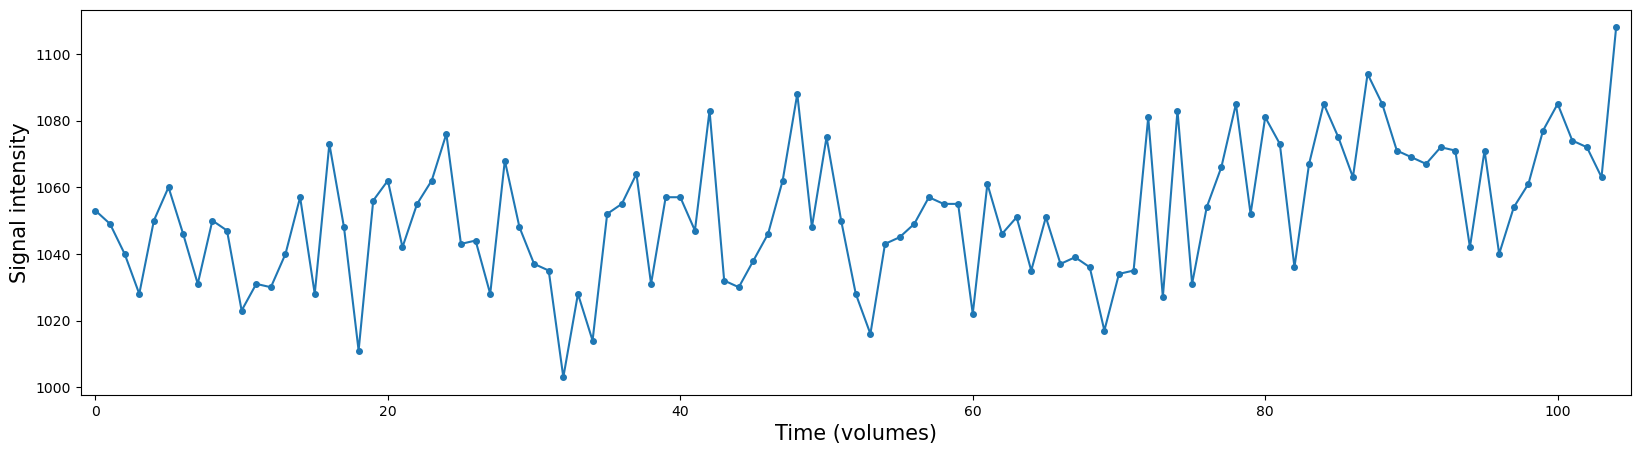

In [39]:
# time-by-time fluctuations in signal intensity by plotting the time series directly
plt.figure(figsize=(20, 5))
plt.plot(mid_vox_ts, 'o-', ms=4)
plt.xlim(-1, mid_vox_ts.size)
#plt.ylim(38000, 55000)
plt.ylabel('Signal intensity', fontsize=15)
plt.xlabel('Time (volumes)', fontsize=15)
plt.show()

In [40]:
# get the events
events_df = pd.read_csv('Dataset/dataset/sub-control01/func/sub-control01_task-music_run-1_events.tsv', sep='\t')
events_df

onset  duration      trial_type
0     0.0      33.0           tones
1    33.0       3.0        response
2    36.0      31.5  negative_music
3    67.5       3.0        response
4    70.5      31.5           tones
5   102.0       3.0        response
6   105.0      31.5  positive_music
7   136.5       3.0        response
8   139.5      31.5           tones
9   171.0       3.0        response
10  174.0      31.5  negative_music
11  205.5       3.0        response
12  208.5      31.5           tones
13  240.0       3.0        response
14  243.0      31.5  positive_music
15  274.5       3.0        response
16  277.5      31.5           tones
17  309.0       3.0        response

## Data Preprocessing

### Normalization

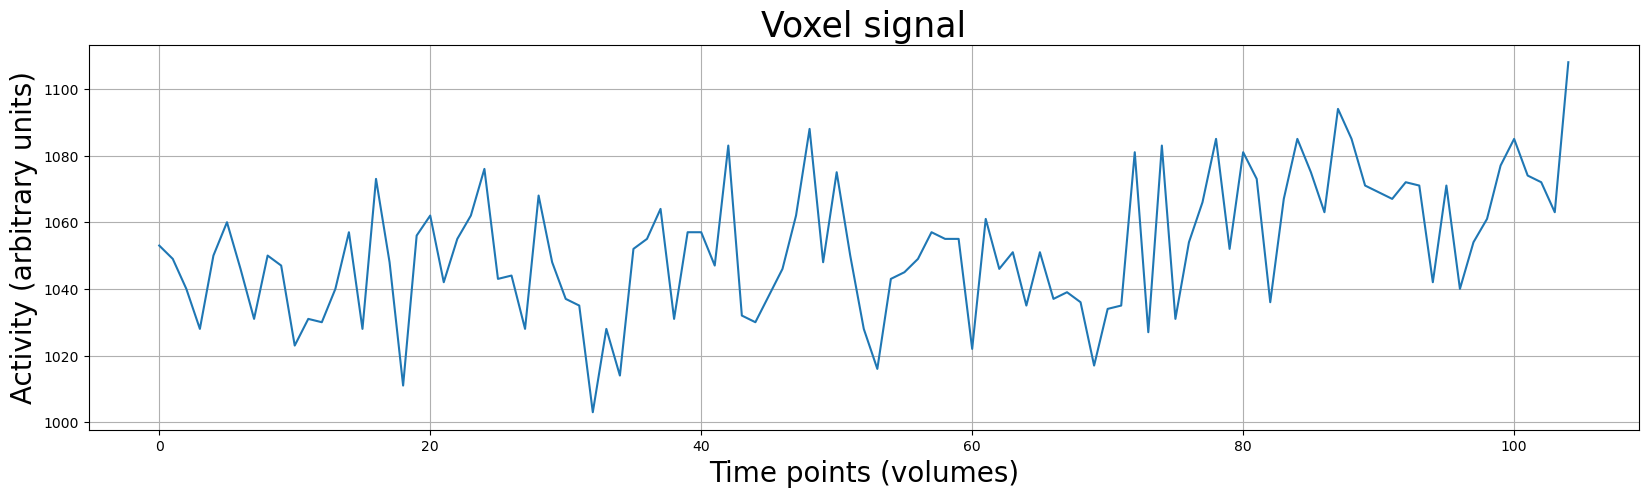

In [41]:
# get signal for a voxel
voxel_signal = f_img_data[39, 39, 24, :]
plt.figure(figsize=(20, 5))
plt.plot(voxel_signal)
plt.xlabel('Time points (volumes)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.title('Voxel signal', fontsize=25)
plt.grid()
plt.show()

In [42]:
# Deal with mean-shift (transform time-series data from non-stationary to stationary)
temp_df = pd.DataFrame(voxel_signal)
voxel_signal_stationary = temp_df[0].diff()  # diff() function take the difference of the data point and its previous point

# the first data point is recorded to 'nan' after transformation (because it does have anything before it to subtract with)
# impute that first value with the mean
voxel_signal_stationary = voxel_signal_stationary.fillna(voxel_signal_stationary.mean())
temp_voxel_signal = voxel_signal_stationary.to_numpy()

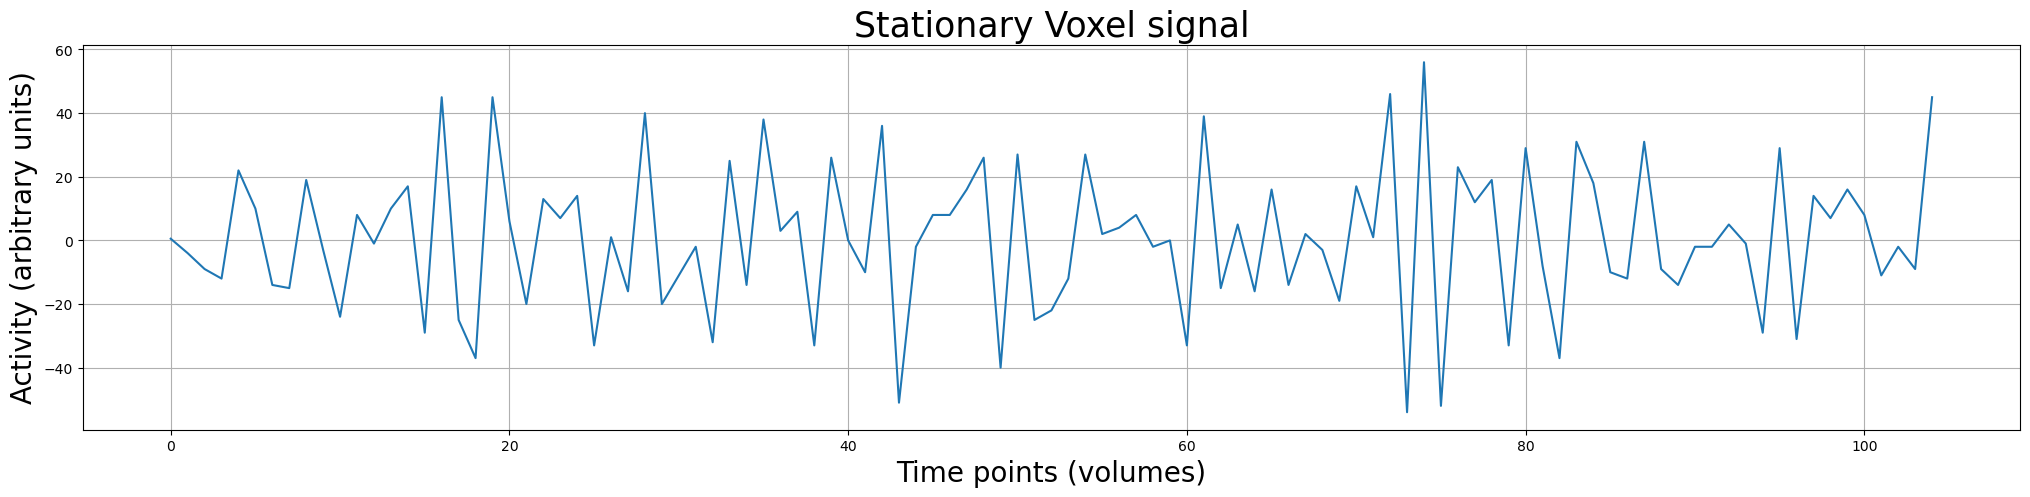

In [43]:
# try plotting the transformed
voxel_signal = temp_voxel_signal
plt.figure(figsize=(25, 5))
plt.plot(voxel_signal)
plt.xlabel('Time points (volumes)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
# plt.xlim(x_lim)
# plt.ylim(y_lim)
plt.title('Stationary Voxel signal', fontsize=25)
plt.grid()
plt.show()

### Convert s to ms

### not converting s to ms (lose some accuracy)

In [44]:
events_df

onset  duration      trial_type
0     0.0      33.0           tones
1    33.0       3.0        response
2    36.0      31.5  negative_music
3    67.5       3.0        response
4    70.5      31.5           tones
5   102.0       3.0        response
6   105.0      31.5  positive_music
7   136.5       3.0        response
8   139.5      31.5           tones
9   171.0       3.0        response
10  174.0      31.5  negative_music
11  205.5       3.0        response
12  208.5      31.5           tones
13  240.0       3.0        response
14  243.0      31.5  positive_music
15  274.5       3.0        response
16  277.5      31.5           tones
17  309.0       3.0        response

In [45]:
## record the response onset in arrays
response_onsets = events_df[events_df['trial_type'] == 'negative_music']
response_onsets = response_onsets.append(events_df[events_df['trial_type'] == 'positive_music'])
onsets = response_onsets['onset'].to_numpy()
onsets = onsets.astype(int)
onsets

array([ 36, 174, 105, 243])

In [46]:
## make a range of onsets
onset_range = []
for onset in onsets:
    onset_range = onset_range + list(range(onset,onset+32))

In [47]:
## convert the onset array to a proper predictor (with the same shape as the fMRI signal)
# for congruent condition
predictor = np.zeros(105*3)   # length of experiment is 105 volume with TR = 3s 
predictor[onset_range] = 1  # set the predictor at the indices to 1
print("Shape of predictor: %s" % (predictor.shape,))
print("\nContents of predictor array:\n%r" % predictor.T)

Shape of predictor: (315,)

Contents of predictor array:
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 

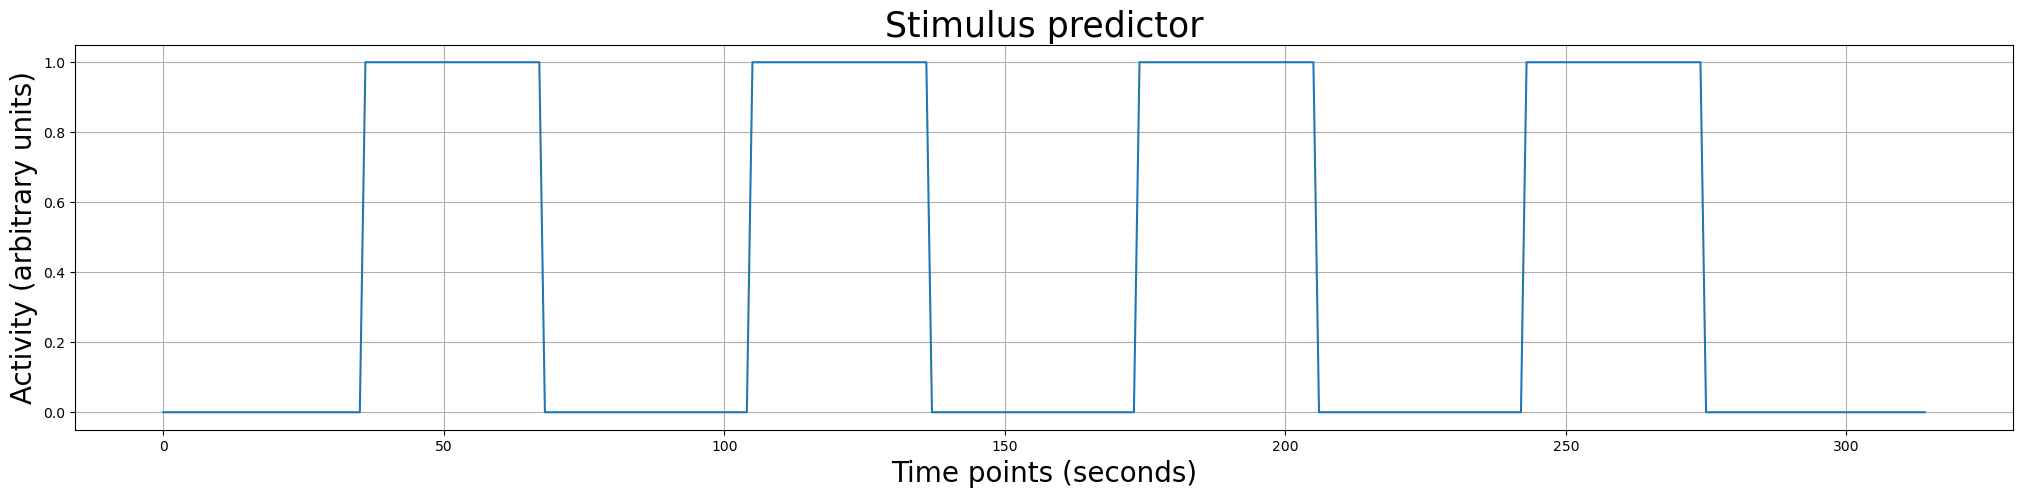

In [48]:
## visualizing the predictor
plt.figure(figsize=(25, 5))
#plt.plot(predictor_congruent, marker='o')
plt.plot(predictor, c='tab:blue')
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
#plt.xlim(0, 300)
#plt.ylim(-.5, 1.5)
plt.title('Stimulus predictor', fontsize=25)
plt.grid()
plt.show()

In [49]:
## since the voxel in fMRI was measured in volume with TR of 3 seconds, we have to down sampling the predictor to fit the same unit of time.
from scipy.interpolate import interp1d

original_scale = np.arange(0, 105*3, 1) # from 0 to 105*3 seconds
print("Original scale has %i datapoints (0-315, in seconds)" % original_scale.size)
resampler = interp1d(original_scale, predictor)
desired_scale = np.arange(0, 105*3, 3)
print("Desired scale has %i datapoints (0, 3, 6, ... 105, in volumes)" % desired_scale.size)
predictor_ds = resampler(desired_scale)
print("Downsampled predictor has %i datapoints (in volumes)" % predictor_ds.size)
print(predictor_ds)

Original scale has 315 datapoints (0-315, in seconds)
Desired scale has 105 datapoints (0, 3, 6, ... 105, in volumes)
Downsampled predictor has 105 datapoints (in volumes)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


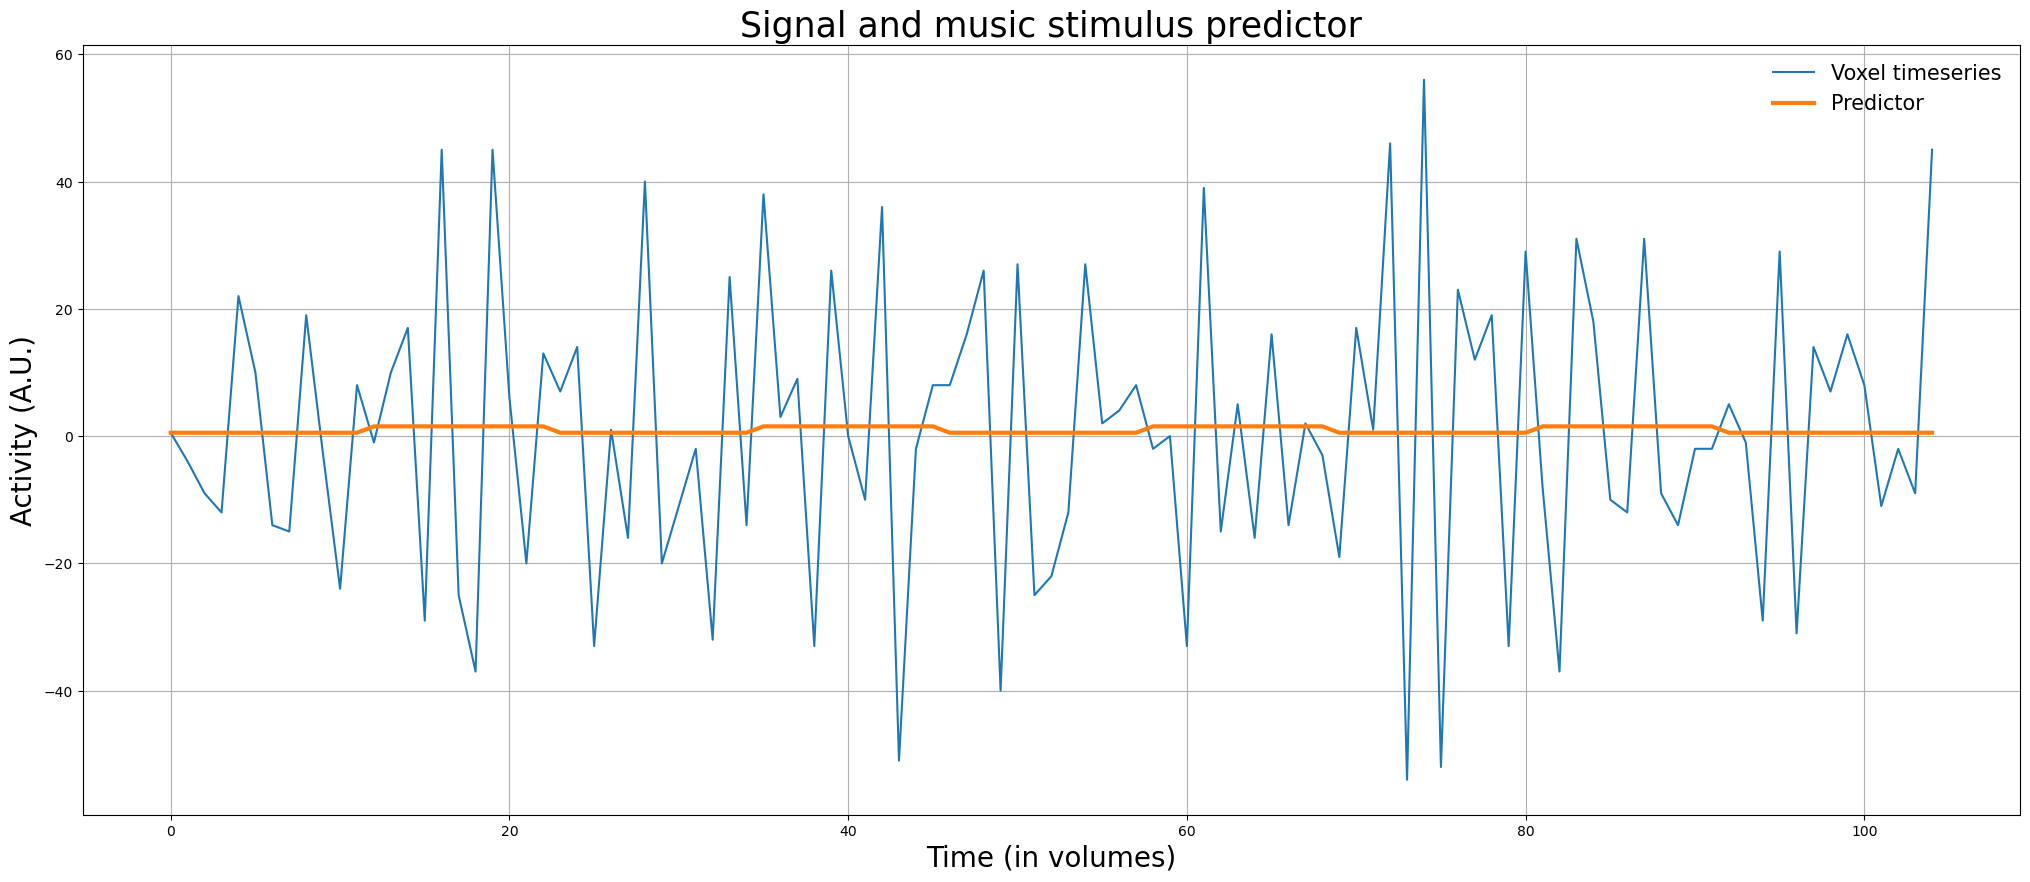

In [50]:
## inspecting the predictor and the actual signal before moving on to linear regression
plt.figure(figsize=(25, 10))
plt.plot(voxel_signal)
plt.plot(predictor_ds + voxel_signal.mean(), lw=3)
plt.xlabel('Time (in volumes)', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.legend(['Voxel timeseries', 'Predictor'], fontsize=15, loc='upper right', frameon=False)
plt.title("Signal and music stimulus predictor", fontsize=25)
plt.grid()
plt.show()

In [51]:
# Regression
if predictor_ds.ndim == 1: # This adds a singleton dimension, such that you can call np.hstack on it
    predictor_ds = predictor_ds[:, np.newaxis]

icept = np.ones((predictor_ds.size, 1))
X_simple = np.hstack((icept, predictor_ds))
betas_simple = inv(X_simple.T @ X_simple) @ X_simple.T @ voxel_signal
y_hat = X_simple[:, 0] * betas_simple[0] + X_simple[:, 1] * betas_simple[1]
print(betas_simple)
numerator = np.sum((voxel_signal - y_hat) ** 2) 
denominator = np.sum((voxel_signal - np.mean(voxel_signal)) ** 2)
r_squared = 1 - numerator / denominator
print('The R² value is: %.3f' % r_squared)

[ 0.6971942  -0.40173965]
The R² value is: 0.000


In [52]:
# function for plotting predicted signal vs. actual signal
def plot_signal_and_predicted_signal(y, X, x_lim=None, y_lim=None):
    """ Plots a signal and its GLM prediction. """
    des = np.hstack((np.ones((y.size, 1)), X))
    betas_simple = np.linalg.lstsq(des, y, rcond=None)[0]
    plt.figure(figsize=(15, 5))
    plt.plot(y)
    plt.plot(des @ betas_simple, lw=2)
    plt.xlabel('Time (in volumes)', fontsize=15)
    plt.ylabel('Activity (A.U.)', fontsize=15)

#     if x_lim is not None:
#         plt.xlim(x_lim)

#     if y_lim is not None:
#         plt.ylim(y_lim)

    plt.legend(['True signal', 'Predicted signal'], loc='upper right', fontsize=15)
    plt.title("Signal and predicted signal", fontsize=25)
    plt.grid()
    plt.show()


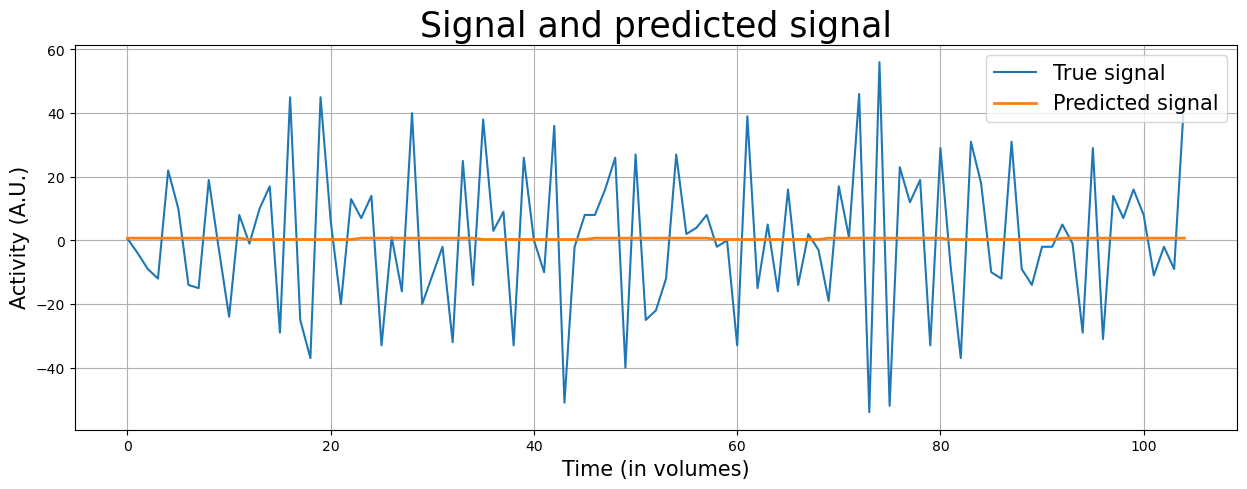

In [53]:
# plotting predicted signal vs. actual signal
plot_signal_and_predicted_signal(voxel_signal, predictor_ds)

In [54]:
# Now, model with BOLD response function
# install nilearn package
# import sys
# !{sys.executable} -m pip install nilearn

# use glover_hrf from nilearn
from nilearn.glm.first_level.hemodynamic_models import glover_hrf

# creating the canonical HFR 
TR = 3
osf = 3
length_hrf = 31 # sec # have to shape it according to our data (let's say to match the ITI of the experiment)
canonical_hrf = glover_hrf(tr=TR, oversampling=osf, time_length=length_hrf, onset=0)
canonical_hrf /= canonical_hrf.max()
print("Size of canonical hrf variable: %i" % canonical_hrf.size)

Size of canonical hrf variable: 31


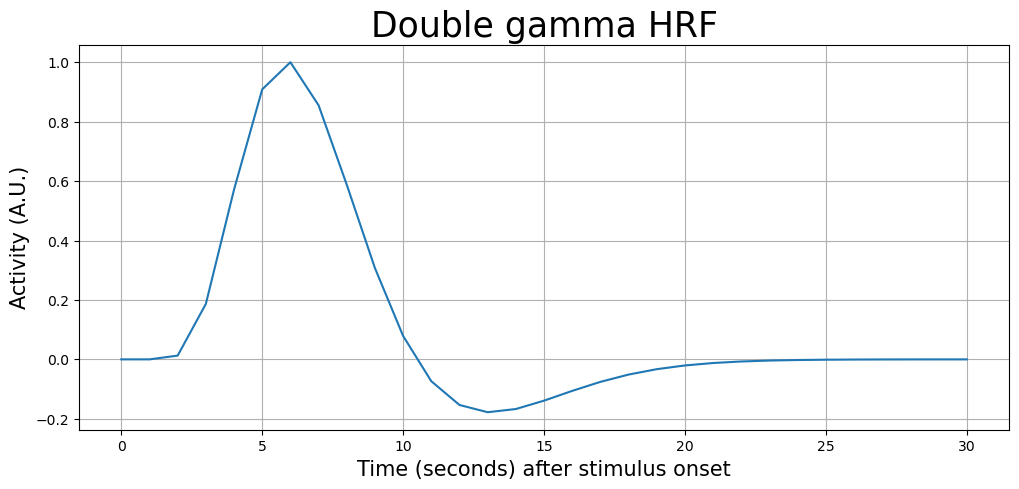

In [55]:
# visualizing the canonical HRF
t = np.arange(0, canonical_hrf.size)
plt.figure(figsize=(12, 5))
plt.plot(t,canonical_hrf)
plt.xlabel('Time (seconds) after stimulus onset', fontsize=15)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.title('Double gamma HRF', fontsize=25)
plt.grid()
plt.show()

In [56]:
# convolve the predictor with the HRF
predictor_conv = np.convolve(predictor.squeeze(), canonical_hrf)
print("The shape of the convolved predictor after convolution: %s" % (predictor_conv.shape,))

# After convolution, we also neem to "trim" off some excess values from the convolved signal 
predictor_conv = predictor_conv[:predictor.size]
print("After trimming, the shape is: %s" % (predictor_conv.shape,))

# And we have to add a new axis again to go from shape (N,) to (N, 1), which is important for stacking the intercept later
predictor_conv = predictor_conv[:, np.newaxis]
print("Shape after adding the new axis: %s" % (predictor_conv.shape,))

The shape of the convolved predictor after convolution: (345,)
After trimming, the shape is: (315,)
Shape after adding the new axis: (315, 1)


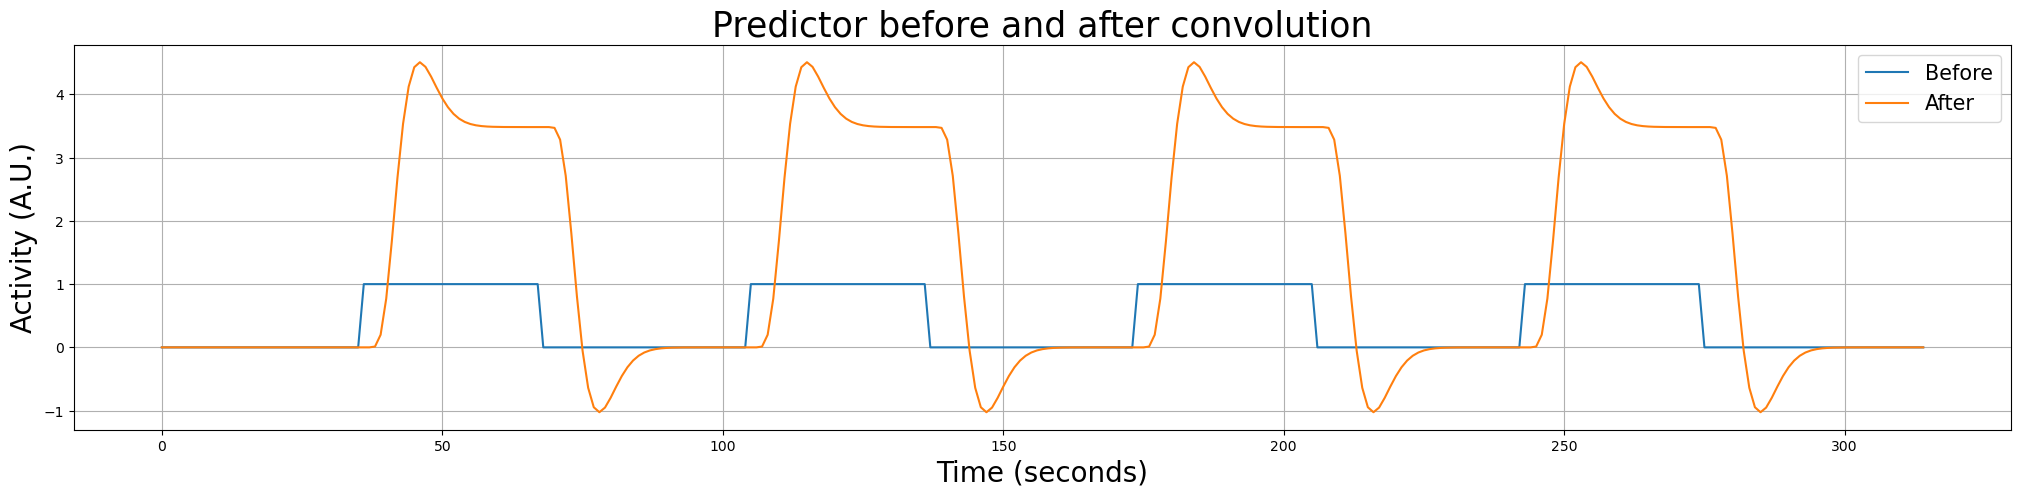

In [57]:
# visualizing the predictor before and after the convolution
# congruent 
plt.figure(figsize=(25, 5))
plt.plot(predictor)
plt.plot(predictor_conv)
#plt.xlim(-1, 800)
plt.title("Predictor before and after convolution", fontsize=25)
plt.xlabel("Time (seconds)", fontsize=20)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.legend(['Before', 'After'], loc='upper right', fontsize=15)
plt.grid()
plt.show()

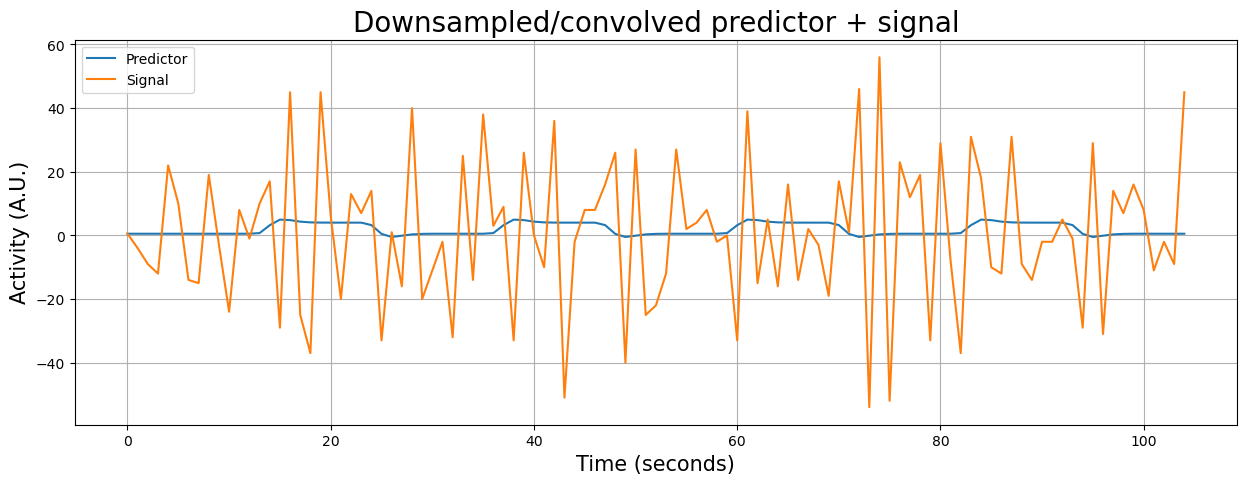

In [58]:
# scale the convolved predictor back to the scale of volume
original_scale = np.arange(0, 105*3, 1) # from 0 to 105*3 seconds
resampler = interp1d(original_scale, np.squeeze(predictor_conv))
desired_scale = np.arange(0, 105*3, 3)
predictor_conv_ds = resampler(desired_scale)
# x_lim, y_lim = (0, 400), (990, 1020)
plt.figure(figsize=(15, 5))
plt.plot(predictor_conv_ds + voxel_signal.mean())
plt.plot(voxel_signal)
plt.grid()
plt.title('Downsampled/convolved predictor + signal', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.legend(['Predictor', 'Signal'])
# plt.xlim(x_lim)
plt.show()

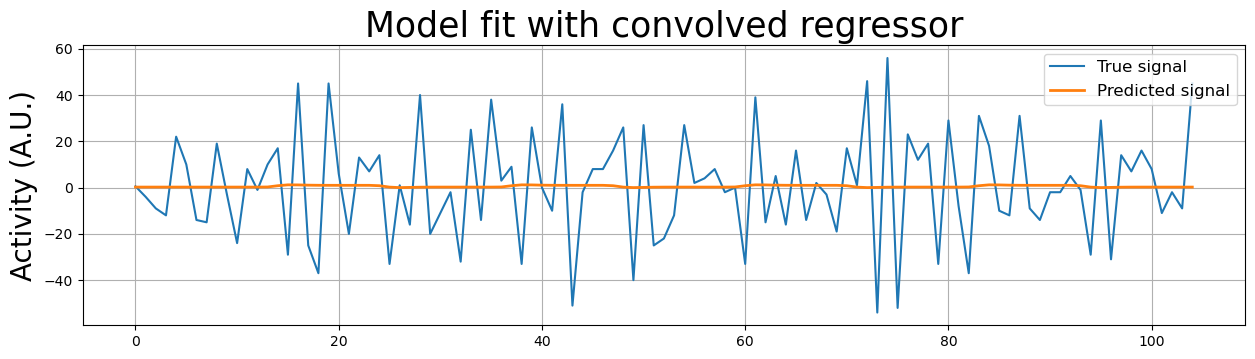

In [59]:
# Now, fitting convolved predictor in GLM
if predictor_conv_ds.ndim == 1:
    # Add back a singleton axis (which was removed before downsampling)
    # otherwise stacking will give an error
    predictor_conv_ds = predictor_conv_ds[:, np.newaxis]
    
intercept = np.ones((predictor_conv_ds.size, 1))
X_conv = np.hstack((intercept, predictor_conv_ds))
betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ voxel_signal
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(voxel_signal)
plt.plot(X_conv @ betas_conv, lw=2)
# plt.xlim(x_lim)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with convolved regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.grid()

In [60]:
# Evaluate the model
from numpy.linalg import lstsq # numpy implementation of OLS, because we're lazy
y_hat_conv = X_conv @ betas_conv
y_hat_orig = X_simple @ lstsq(X_simple, voxel_signal, rcond=None)[0]
MSE_conv = ((y_hat_conv - voxel_signal) ** 2).mean()
MSE_orig = ((y_hat_orig - voxel_signal) ** 2).mean()
print("MSE of model with convolution is %.3f while the MSE of the model without convolution is %.3f." %
 (MSE_conv, MSE_orig))
R2_conv = 1 - (np.sum((voxel_signal - y_hat_conv) ** 2) / np.sum((voxel_signal - voxel_signal.mean()) ** 2))
R2_orig = 1 - (np.sum((voxel_signal - y_hat_orig) ** 2) / np.sum((voxel_signal - voxel_signal.mean()) ** 2))
print("R-squared of model with convolution is %.5f and without convolution it is %.5f." %
 (R2_conv, R2_orig))

MSE of model with convolution is 534.770 while the MSE of the model without convolution is 534.893.
R-squared of model with convolution is 0.00030 and without convolution it is 0.00007.


# T-maps Music

## Sub-control01 Run-1

In [69]:
# importing the functional MRI data file
fmri_file = 'Dataset/dataset/sub-control01/func/sub-control01_task-music_run-1_bold.nii.gz'
f_img = nib.load(fmri_file)
# getting fMRI data
f_img_data = f_img.get_fdata()

In [70]:
def design_variance(X, which_predictor=1): # X : Numpy Array of shape (N, P) 
    is_single = isinstance(which_predictor, int)
    if is_single:
        idx = which_predictor
    else:
        idx = np.array(which_predictor) != 0

    c = np.zeros(X.shape[1])
    c[idx] = 1 if is_single == 1 else which_predictor[idx]
    des_var = c.dot(np.linalg.inv(X.T.dot(X))).dot(c.T)
    return des_var

In [71]:
# get a statistical map (a for loop to compute t-value of every voxel)
t_map = f_img_data[:, :, :, 0]  # to store t-values of each voxel (3D map)
for i in range(f_img_data.shape[0]):
    for j in range(f_img_data.shape[1]):
        for k in range(f_img_data.shape[2]):
            voxel_signal = f_img_data[i, j, k, :]
            # start the regression
            if predictor_conv_ds.ndim == 1:
                # Add back a singleton axis (which was removed before downsampling)
                # otherwise stacking will give an error
                predictor_conv_ds = predictor_conv_ds[:, np.newaxis]
            # linear regression    
            intercept = np.ones((predictor_conv_ds.size, 1))
            X_conv = np.hstack((intercept, predictor_conv_ds))
            betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ voxel_signal
            design_variance_predictor = design_variance(X_conv, which_predictor=1)  # get design variance
            # get degree of freedom and noise terms
            y_hat = X_conv @ betas_conv
            N = voxel_signal.size
            P = X_conv.shape[1]
            df = (N - P)  # degree of freedom
            sigma_hat = np.sum((voxel_signal - y_hat) ** 2) / df # noise
            #get t-value
            t = betas_conv[1] / np.sqrt(sigma_hat * design_variance_predictor)
            if math.isnan(t):
                t = 0
            # store the t-value in t-map
            t_map[i, j, k] = round(t, 3)         

In [72]:
t_map

array([[[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        ...,
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]],

       [[ 0.613, -0.644,  1.372, ...,  0.004,  0.363,  0.117],
        [ 1.311,  0.339,  0.391, ..., -0.286,  0.629,  0.258],
        [ 0.425, -1.058,  1.886, ..., -0.873, -0.139,  1.298],
        ...,
        [-1.761, -1.145,  0.513, ..., -0.708,  0.4  ,  1.096],
        [-0.751, -0.579,  0.814, ...,  1.793,  2.232, -0.936],
        [ 1.391, -1.322, -0.046, ...,  0.075, -0.561,  0.142]],

       [[-0.61 , -0.555,  2.   , ...,  1.486, -0.067,  0.132],
        [ 0.666,  0.158,  0.731, ...,  0.565, -0.675,  0.477],
        [-0.593, -1.193,  2.069, ..., -1.729, -1.478, -2.209],
        ...,
        [-0.

In [73]:
## convert t-map to NifTi image

# load the data
func = nib.load(fmri_file)

# to save this 3D (ndarry) numpy use this
ni_img = nib.Nifti1Image(t_map, func.affine)

In [ ]:
# Get a cortical mesh
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()

In [ ]:
print(fsaverage['description'])

In [ ]:
# Sample the 3D data around each node of the mesh
from nilearn import surface
texture = surface.vol_to_surf(ni_img, fsaverage.pial_right)

In [ ]:
# plot the result 
from nilearn import plotting

# fig = plotting.plot_surf_stat_map(
#     fsaverage.infl_right, texture, hemi='right',
#     title='Surface right hemisphere', colorbar=True,
#     threshold=0, bg_map=fsaverage.sulc_right,
#     engine='plotly'
# )

fig = plotting.plot_surf_stat_map(fsaverage.pial_left, texture, engine='plotly')
fig.show()

In [ ]:
# plot the result 
from nilearn import plotting

# fig = plotting.plot_surf_stat_map(
#     fsaverage.infl_right, texture, hemi='right',
#     title='Surface right hemisphere', colorbar=True,
#     threshold=0, bg_map=fsaverage.sulc_right,
#     engine='plotly'
# )

fig = plotting.plot_surf_stat_map(fsaverage.pial_left, texture, cmap = 'PRGn', engine='plotly', threshold="90%", title='Left hemisphere')
fig.show()

In [ ]:
fig = plotting.plot_surf_stat_map(fsaverage.pial_right, texture, engine='plotly')
fig.show()

In [ ]:
fig = plotting.plot_surf_stat_map(fsaverage.pial_right, texture, cmap = 'PRGn', engine='plotly', threshold="90%", title='Right hemisphere')
fig.show()

## Sub-control02 Run-3

In [ ]:
# importing the functional MRI data file
fmri_file = 'Dataset/dataset/sub-control02/func/sub-control02_task-music_run-3_bold.nii.gz'

# getting fMRI data
f_img_data = f_img.get_fdata()

In [ ]:
def design_variance(X, which_predictor=1): # X : Numpy Array of shape (N, P) 
    is_single = isinstance(which_predictor, int)
    if is_single:
        idx = which_predictor
    else:
        idx = np.array(which_predictor) != 0

    c = np.zeros(X.shape[1])
    c[idx] = 1 if is_single == 1 else which_predictor[idx]
    des_var = c.dot(np.linalg.inv(X.T.dot(X))).dot(c.T)
    return des_var

In [ ]:
# get a statistical map (a for loop to compute t-value of every voxel)
t_map = f_img_data[:, :, :, 0]  # to store t-values of each voxel (3D map)
for i in range(f_img_data.shape[0]):
    for j in range(f_img_data.shape[1]):
        for k in range(f_img_data.shape[2]):
            voxel_signal = f_img_data[i, j, k, :]
            # start the regression
            if predictor_conv_ds.ndim == 1:
                # Add back a singleton axis (which was removed before downsampling)
                # otherwise stacking will give an error
                predictor_conv_ds = predictor_conv_ds[:, np.newaxis]
            # linear regression    
            intercept = np.ones((predictor_conv_ds.size, 1))
            X_conv = np.hstack((intercept, predictor_conv_ds))
            betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ voxel_signal
            design_variance_predictor = design_variance(X_conv, which_predictor=1)  # get design variance
            # get degree of freedom and noise terms
            y_hat = X_conv @ betas_conv
            N = voxel_signal.size
            P = X_conv.shape[1]
            df = (N - P)  # degree of freedom
            sigma_hat = np.sum((voxel_signal - y_hat) ** 2) / df # noise
            #get t-value
            t = betas_conv[1] / np.sqrt(sigma_hat * design_variance_predictor)
            if math.isnan(t):
                t = 0
            # store the t-value in t-map
            t_map[i, j, k] = round(t, 3)         

In [ ]:
## convert t-map to NifTi image

# load the data
func = nib.load(fmri_file)

# to save this 3D (ndarry) numpy use this
ni_img = nib.Nifti1Image(t_map, func.affine)

In [ ]:
# Get a cortical mesh
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()

In [ ]:
# Sample the 3D data around each node of the mesh
from nilearn import surface
texture = surface.vol_to_surf(ni_img, fsaverage.pial_right)

In [ ]:
# plot the result 
from nilearn import plotting

fig = plotting.plot_surf_stat_map(fsaverage.pial_left, texture, cmap = 'PRGn', engine='plotly')
fig.show()

In [ ]:
fig = plotting.plot_surf_stat_map(fsaverage.pial_right, texture, cmap = 'PRGn', engine='plotly', threshold=0)
fig.show()

## Sub-mdd01 Run-1

In [ ]:
# importing the functional MRI data file
fmri_file = 'Dataset/dataset/sub-mdd01/func/sub-mdd01_task-music_run-1_bold.nii.gz'
f_img = nib.load(fmri_file)
# getting fMRI data
f_img_data = f_img.get_fdata()

In [ ]:
def design_variance(X, which_predictor=1): # X : Numpy Array of shape (N, P) 
    is_single = isinstance(which_predictor, int)
    if is_single:
        idx = which_predictor
    else:
        idx = np.array(which_predictor) != 0

    c = np.zeros(X.shape[1])
    c[idx] = 1 if is_single == 1 else which_predictor[idx]
    des_var = c.dot(np.linalg.inv(X.T.dot(X))).dot(c.T)
    return des_var

In [ ]:
# get a statistical map (a for loop to compute t-value of every voxel)
t_map = f_img_data[:, :, :, 0]  # to store t-values of each voxel (3D map)
for i in range(f_img_data.shape[0]):
    for j in range(f_img_data.shape[1]):
        for k in range(f_img_data.shape[2]):
            voxel_signal = f_img_data[i, j, k, :]
            # start the regression
            if predictor_conv_ds.ndim == 1:
                # Add back a singleton axis (which was removed before downsampling)
                # otherwise stacking will give an error
                predictor_conv_ds = predictor_conv_ds[:, np.newaxis]
            # linear regression    
            intercept = np.ones((predictor_conv_ds.size, 1))
            X_conv = np.hstack((intercept, predictor_conv_ds))
            betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ voxel_signal
            design_variance_predictor = design_variance(X_conv, which_predictor=1)  # get design variance
            # get degree of freedom and noise terms
            y_hat = X_conv @ betas_conv
            N = voxel_signal.size
            P = X_conv.shape[1]
            df = (N - P)  # degree of freedom
            sigma_hat = np.sum((voxel_signal - y_hat) ** 2) / df # noise
            #get t-value
            t = betas_conv[1] / np.sqrt(sigma_hat * design_variance_predictor)
            if math.isnan(t):
                t = 0
            # store the t-value in t-map
            t_map[i, j, k] = round(t, 3)         

In [ ]:
## convert t-map to NifTi image

# load the data
func = nib.load(fmri_file)

# to save this 3D (ndarry) numpy use this
ni_img = nib.Nifti1Image(t_map, func.affine)

In [ ]:
# Get a cortical mesh
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()

In [ ]:
# Sample the 3D data around each node of the mesh
from nilearn import surface
texture = surface.vol_to_surf(ni_img, fsaverage.pial_right)

In [ ]:
# plot the result 
from nilearn import plotting

fig = plotting.plot_surf_stat_map(fsaverage.pial_left, texture, cmap = 'PRGn', engine='plotly', threshold="90%", title='Left hemisphere')
fig.show()

In [ ]:
fig = plotting.plot_surf_stat_map(fsaverage.pial_right, texture, cmap = 'PRGn', engine='plotly', threshold="90%", title='Right hemisphere')
fig.show()

## Sub-mdd03 Run-1

In [ ]:
# importing the functional MRI data file
fmri_file = 'Dataset/dataset/sub-mdd03/func/sub-mdd03_task-music_run-1_bold.nii.gz'

# getting fMRI data
f_img_data = f_img.get_fdata()

In [ ]:
def design_variance(X, which_predictor=1): # X : Numpy Array of shape (N, P) 
    is_single = isinstance(which_predictor, int)
    if is_single:
        idx = which_predictor
    else:
        idx = np.array(which_predictor) != 0

    c = np.zeros(X.shape[1])
    c[idx] = 1 if is_single == 1 else which_predictor[idx]
    des_var = c.dot(np.linalg.inv(X.T.dot(X))).dot(c.T)
    return des_var

In [ ]:
# get a statistical map (a for loop to compute t-value of every voxel)
t_map = f_img_data[:, :, :, 0]  # to store t-values of each voxel (3D map)
for i in range(f_img_data.shape[0]):
    for j in range(f_img_data.shape[1]):
        for k in range(f_img_data.shape[2]):
            voxel_signal = f_img_data[i, j, k, :]
            # start the regression
            if predictor_conv_ds.ndim == 1:
                # Add back a singleton axis (which was removed before downsampling)
                # otherwise stacking will give an error
                predictor_conv_ds = predictor_conv_ds[:, np.newaxis]
            # linear regression    
            intercept = np.ones((predictor_conv_ds.size, 1))
            X_conv = np.hstack((intercept, predictor_conv_ds))
            betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ voxel_signal
            design_variance_predictor = design_variance(X_conv, which_predictor=1)  # get design variance
            # get degree of freedom and noise terms
            y_hat = X_conv @ betas_conv
            N = voxel_signal.size
            P = X_conv.shape[1]
            df = (N - P)  # degree of freedom
            sigma_hat = np.sum((voxel_signal - y_hat) ** 2) / df # noise
            #get t-value
            t = betas_conv[1] / np.sqrt(sigma_hat * design_variance_predictor)
            if math.isnan(t):
                t = 0
            # store the t-value in t-map
            t_map[i, j, k] = round(t, 3)         

In [ ]:
## convert t-map to NifTi image

# load the data
func = nib.load(fmri_file)

# to save this 3D (ndarry) numpy use this
ni_img = nib.Nifti1Image(t_map, func.affine)

In [ ]:
# Get a cortical mesh
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()

In [ ]:
# Sample the 3D data around each node of the mesh
from nilearn import surface
texture = surface.vol_to_surf(ni_img, fsaverage.pial_right)

In [ ]:
# plot the result 
from nilearn import plotting

fig = plotting.plot_surf_stat_map(fsaverage.pial_left, texture, cmap = 'PRGn', engine='plotly')
fig.show()

In [ ]:
fig = plotting.plot_surf_stat_map(fsaverage.pial_right, texture, cmap = 'PRGn', engine='plotly', threshold="95%", title='Right hemisphere')
fig.show()

## Sub-control16 Run-1

In [ ]:
# importing the functional MRI data file
fmri_file = 'Dataset/dataset/sub-control16/func/sub-control16_task-music_run-3_bold.nii.gz'

# getting fMRI data
f_img_data = f_img.get_fdata()

In [ ]:
def design_variance(X, which_predictor=1): # X : Numpy Array of shape (N, P) 
    is_single = isinstance(which_predictor, int)
    if is_single:
        idx = which_predictor
    else:
        idx = np.array(which_predictor) != 0

    c = np.zeros(X.shape[1])
    c[idx] = 1 if is_single == 1 else which_predictor[idx]
    des_var = c.dot(np.linalg.inv(X.T.dot(X))).dot(c.T)
    return des_var

In [ ]:
# get a statistical map (a for loop to compute t-value of every voxel)
t_map = f_img_data[:, :, :, 0]  # to store t-values of each voxel (3D map)
for i in range(f_img_data.shape[0]):
    for j in range(f_img_data.shape[1]):
        for k in range(f_img_data.shape[2]):
            voxel_signal = f_img_data[i, j, k, :]
            # start the regression
            if predictor_conv_ds.ndim == 1:
                # Add back a singleton axis (which was removed before downsampling)
                # otherwise stacking will give an error
                predictor_conv_ds = predictor_conv_ds[:, np.newaxis]
            # linear regression    
            intercept = np.ones((predictor_conv_ds.size, 1))
            X_conv = np.hstack((intercept, predictor_conv_ds))
            betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ voxel_signal
            design_variance_predictor = design_variance(X_conv, which_predictor=1)  # get design variance
            # get degree of freedom and noise terms
            y_hat = X_conv @ betas_conv
            N = voxel_signal.size
            P = X_conv.shape[1]
            df = (N - P)  # degree of freedom
            sigma_hat = np.sum((voxel_signal - y_hat) ** 2) / df # noise
            #get t-value
            t = betas_conv[1] / np.sqrt(sigma_hat * design_variance_predictor)
            if math.isnan(t):
                t = 0
            # store the t-value in t-map
            t_map[i, j, k] = round(t, 3)         

In [ ]:
## convert t-map to NifTi image

# load the data
func = nib.load(fmri_file)

# to save this 3D (ndarry) numpy use this
ni_img = nib.Nifti1Image(t_map, func.affine)

In [ ]:
# Get a cortical mesh
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()

In [ ]:
# Sample the 3D data around each node of the mesh
from nilearn import surface
texture = surface.vol_to_surf(ni_img, fsaverage.pial_right)

In [ ]:
# plot the result 
from nilearn import plotting

fig = plotting.plot_surf_stat_map(fsaverage.pial_left, texture, cmap = 'PRGn', engine='plotly')
fig.show()

In [ ]:
fig = plotting.plot_surf_stat_map(fsaverage.pial_right, texture, cmap = 'PRGn', engine='plotly', threshold=0)
fig.show()

## Sub-mdd14 Run-1

In [ ]:
# importing the functional MRI data file
fmri_file = 'Dataset/dataset/sub-mdd14/func/sub-mdd14_task-music_run-3_bold.nii.gz'

# getting fMRI data
f_img_data = f_img.get_fdata()

In [ ]:
def design_variance(X, which_predictor=1): # X : Numpy Array of shape (N, P) 
    is_single = isinstance(which_predictor, int)
    if is_single:
        idx = which_predictor
    else:
        idx = np.array(which_predictor) != 0

    c = np.zeros(X.shape[1])
    c[idx] = 1 if is_single == 1 else which_predictor[idx]
    des_var = c.dot(np.linalg.inv(X.T.dot(X))).dot(c.T)
    return des_var

In [ ]:
# get a statistical map (a for loop to compute t-value of every voxel)
t_map = f_img_data[:, :, :, 0]  # to store t-values of each voxel (3D map)
for i in range(f_img_data.shape[0]):
    for j in range(f_img_data.shape[1]):
        for k in range(f_img_data.shape[2]):
            voxel_signal = f_img_data[i, j, k, :]
            # start the regression
            if predictor_conv_ds.ndim == 1:
                # Add back a singleton axis (which was removed before downsampling)
                # otherwise stacking will give an error
                predictor_conv_ds = predictor_conv_ds[:, np.newaxis]
            # linear regression    
            intercept = np.ones((predictor_conv_ds.size, 1))
            X_conv = np.hstack((intercept, predictor_conv_ds))
            betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ voxel_signal
            design_variance_predictor = design_variance(X_conv, which_predictor=1)  # get design variance
            # get degree of freedom and noise terms
            y_hat = X_conv @ betas_conv
            N = voxel_signal.size
            P = X_conv.shape[1]
            df = (N - P)  # degree of freedom
            sigma_hat = np.sum((voxel_signal - y_hat) ** 2) / df # noise
            #get t-value
            t = betas_conv[1] / np.sqrt(sigma_hat * design_variance_predictor)
            if math.isnan(t):
                t = 0
            # store the t-value in t-map
            t_map[i, j, k] = round(t, 3)         

In [ ]:
## convert t-map to NifTi image

# load the data
func = nib.load(fmri_file)

# to save this 3D (ndarry) numpy use this
ni_img = nib.Nifti1Image(t_map, func.affine)

In [ ]:
# Get a cortical mesh
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()

In [ ]:
# Sample the 3D data around each node of the mesh
from nilearn import surface
texture = surface.vol_to_surf(ni_img, fsaverage.pial_right)

In [ ]:
# plot the result 
from nilearn import plotting

fig = plotting.plot_surf_stat_map(fsaverage.pial_left, texture, cmap = 'PRGn', engine='plotly', threshold="95%", title='Left hemisphere')
fig.show()

In [ ]:
fig = plotting.plot_surf_stat_map(fsaverage.pial_right, texture, cmap = 'PRGn', engine='plotly', threshold="95%", title='Right hemisphere')
fig.show()

# T-maps Non-Music

## Sub-control01

In [130]:
# importing the functional MRI data file
fmri_file = 'Dataset/dataset/sub-control01/func/sub-control01_task-nonmusic_run-4_bold.nii.gz'
f_img = nib.load(fmri_file)
# getting fMRI data
f_img_data = f_img.get_fdata()

In [131]:
def design_variance(X, which_predictor=1): # X : Numpy Array of shape (N, P) 
    is_single = isinstance(which_predictor, int)
    if is_single:
        idx = which_predictor
    else:
        idx = np.array(which_predictor) != 0

    c = np.zeros(X.shape[1])
    c[idx] = 1 if is_single == 1 else which_predictor[idx]
    des_var = c.dot(np.linalg.inv(X.T.dot(X))).dot(c.T)
    return des_var

In [132]:
# get a statistical map (a for loop to compute t-value of every voxel)
t_map = f_img_data[:, :, :, 0]  # to store t-values of each voxel (3D map)
for i in range(f_img_data.shape[0]):
    for j in range(f_img_data.shape[1]):
        for k in range(f_img_data.shape[2]):
            voxel_signal = f_img_data[i, j, k, :]
            # start the regression
            if predictor_conv_ds.ndim == 1:
                # Add back a singleton axis (which was removed before downsampling)
                # otherwise stacking will give an error
                predictor_conv_ds = predictor_conv_ds[:, np.newaxis]
            # linear regression    
            intercept = np.ones((predictor_conv_ds.size, 1))
            X_conv = np.hstack((intercept, predictor_conv_ds))
            betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ voxel_signal
            design_variance_predictor = design_variance(X_conv, which_predictor=1)  # get design variance
            # get degree of freedom and noise terms
            y_hat = X_conv @ betas_conv
            N = voxel_signal.size
            P = X_conv.shape[1]
            df = (N - P)  # degree of freedom
            sigma_hat = np.sum((voxel_signal - y_hat) ** 2) / df # noise
            #get t-value
            t = betas_conv[1] / np.sqrt(sigma_hat * design_variance_predictor)
            if math.isnan(t):
                t = 0
            # store the t-value in t-map
            t_map[i, j, k] = round(t, 3)         

C:\Users\nasri\AppData\Local\Temp\ipykernel_16608\4060262879.py:24: RuntimeWarning:

invalid value encountered in double_scalars



In [133]:
## convert t-map to NifTi image

# load the data
func = nib.load(fmri_file)

# to save this 3D (ndarry) numpy use this
ni_img = nib.Nifti1Image(t_map, func.affine)

In [134]:
# Get a cortical mesh
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()

In [135]:
# Sample the 3D data around each node of the mesh
from nilearn import surface
texture = surface.vol_to_surf(ni_img, fsaverage.pial_right)

In [ ]:
# plot the result 
from nilearn import plotting

# fig = plotting.plot_surf_stat_map(
#     fsaverage.infl_right, texture, hemi='right',
#     title='Surface right hemisphere', colorbar=True,
#     threshold=0, bg_map=fsaverage.sulc_right,
#     engine='plotly'
# )

fig = plotting.plot_surf_stat_map(fsaverage.pial_left, texture, cmap = 'PRGn', engine='plotly', threshold="90%", title='Left hemisphere')
fig.show()

In [ ]:
fig = plotting.plot_surf_stat_map(fsaverage.pial_right, texture, cmap = 'PRGn', engine='plotly', threshold="90%", title='Right hemisphere')
fig.show()

## Sub-mdd01

In [139]:
# importing the functional MRI data file
fmri_file = 'Dataset/dataset/sub-mdd01/func/sub-mdd01_task-nonmusic_run-4_bold.nii.gz'
f_img = nib.load(fmri_file)
# getting fMRI data
f_img_data = f_img.get_fdata()

In [140]:
def design_variance(X, which_predictor=1): # X : Numpy Array of shape (N, P) 
    is_single = isinstance(which_predictor, int)
    if is_single:
        idx = which_predictor
    else:
        idx = np.array(which_predictor) != 0

    c = np.zeros(X.shape[1])
    c[idx] = 1 if is_single == 1 else which_predictor[idx]
    des_var = c.dot(np.linalg.inv(X.T.dot(X))).dot(c.T)
    return des_var

In [141]:
# get a statistical map (a for loop to compute t-value of every voxel)
t_map = f_img_data[:, :, :, 0]  # to store t-values of each voxel (3D map)
for i in range(f_img_data.shape[0]):
    for j in range(f_img_data.shape[1]):
        for k in range(f_img_data.shape[2]):
            voxel_signal = f_img_data[i, j, k, :]
            # start the regression
            if predictor_conv_ds.ndim == 1:
                # Add back a singleton axis (which was removed before downsampling)
                # otherwise stacking will give an error
                predictor_conv_ds = predictor_conv_ds[:, np.newaxis]
            # linear regression    
            intercept = np.ones((predictor_conv_ds.size, 1))
            X_conv = np.hstack((intercept, predictor_conv_ds))
            betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ voxel_signal
            design_variance_predictor = design_variance(X_conv, which_predictor=1)  # get design variance
            # get degree of freedom and noise terms
            y_hat = X_conv @ betas_conv
            N = voxel_signal.size
            P = X_conv.shape[1]
            df = (N - P)  # degree of freedom
            sigma_hat = np.sum((voxel_signal - y_hat) ** 2) / df # noise
            #get t-value
            t = betas_conv[1] / np.sqrt(sigma_hat * design_variance_predictor)
            if math.isnan(t):
                t = 0
            # store the t-value in t-map
            t_map[i, j, k] = round(t, 3)         

C:\Users\nasri\AppData\Local\Temp\ipykernel_16608\4060262879.py:24: RuntimeWarning:

invalid value encountered in double_scalars



In [142]:
## convert t-map to NifTi image

# load the data
func = nib.load(fmri_file)

# to save this 3D (ndarry) numpy use this
ni_img = nib.Nifti1Image(t_map, func.affine)

In [143]:
# Get a cortical mesh
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()

In [144]:
# Sample the 3D data around each node of the mesh
from nilearn import surface
texture = surface.vol_to_surf(ni_img, fsaverage.pial_right)

In [ ]:
# plot the result 
from nilearn import plotting

# fig = plotting.plot_surf_stat_map(
#     fsaverage.infl_right, texture, hemi='right',
#     title='Surface right hemisphere', colorbar=True,
#     threshold=0, bg_map=fsaverage.sulc_right,
#     engine='plotly'
# )

fig = plotting.plot_surf_stat_map(fsaverage.pial_left, texture, cmap = 'PRGn', engine='plotly', threshold="90%", title='Left hemisphere')
fig.show()

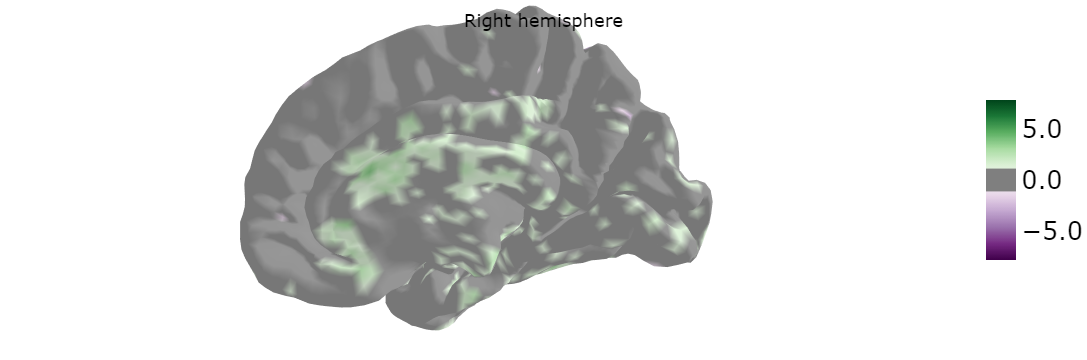

In [146]:
fig = plotting.plot_surf_stat_map(fsaverage.pial_right, texture, cmap = 'PRGn', engine='plotly', threshold="90%", title='Right hemisphere')
fig.show()

# fRIPerps

In [ ]:
# install pybids module
# !{sys.executable} -m pip install pybids

In [ ]:
import bids

In [ ]:
layout = bids.BIDSLayout('dataset/', config=['bids','derivatives'])

In [ ]:
# fetch subjects
layout.get_subjects()

In [ ]:
# fetch tasks
layout.get_tasks()

In [ ]:
# fetching specific files
preproc_T1 = layout.get(datatype='anat', extension=".nii.gz")
preproc_T1

# Connectivity Analysis

In [9]:
## Retrieve the atlas and the data
from nilearn import datasets
atlas = datasets.fetch_atlas_msdl()
# Loading atlas image stored in 'maps'
atlas_filename = atlas['maps']
# Loading atlas data stored in 'labels'
labels = atlas['labels']

## extract time series

from nilearn.maskers import NiftiMapsMasker
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True,
                         memory='nilearn_cache', verbose=5)

time_series = masker.fit_transform(fmri_file)

[NiftiMapsMasker.fit_transform] loading regions from C:\Users\nasri\nilearn_data\msdl_atlas\MSDL_rois\msdl_rois.nii
Resampling maps
[Memory]0.0s, 0.0min    : Loading resample_img...
________________________________________resample_img cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [10]:
# Compute the sparse inverse covariance
try:
    from sklearn.covariance import GraphicalLassoCV
except ImportError:
    # for Scitkit-Learn < v0.20.0
    from sklearn.covariance import GraphLassoCV as GraphicalLassoCV

estimator = GraphicalLassoCV()
estimator.fit(time_series)

GraphicalLassoCV()

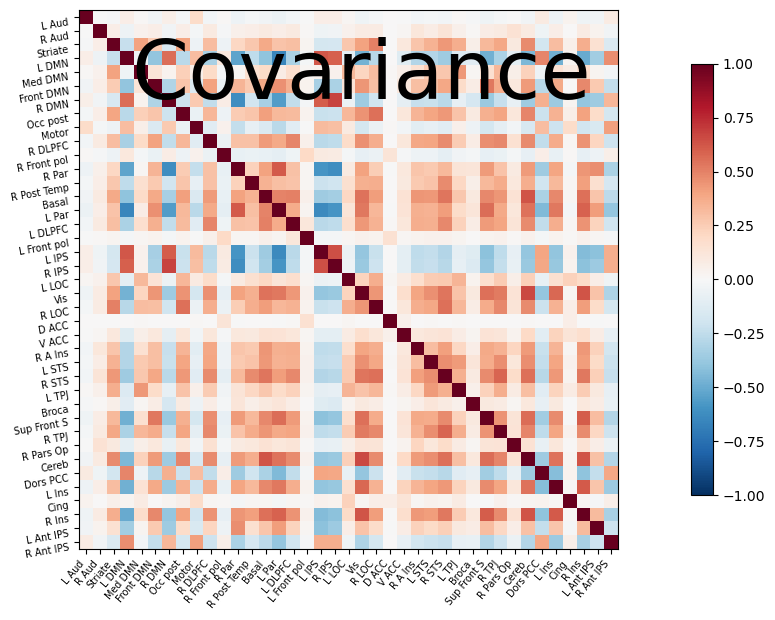

In [11]:
from nilearn import plotting
# Display the covariance
# The covariance can be found at estimator.covariance_
plotting.plot_matrix(estimator.covariance_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                     title='Covariance')

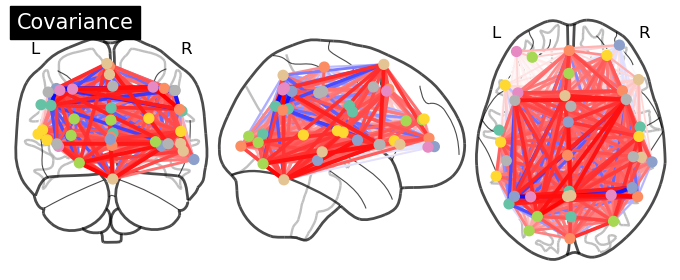

In [12]:
# connectome
coords = atlas.region_coords

plotting.plot_connectome(estimator.covariance_, coords,
                         title='Covariance')

In [ ]:
view = plotting.view_connectome(estimator.covariance_, coords)

# In a Jupyter notebook, if ``view`` is the output of a cell, it will
# be displayed below the cell
view

In [ ]:
# Display the sparse inverse covariance
plotting.plot_matrix(-estimator.precision_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                     title='Sparse inverse covariance')

In [ ]:
# connectome
plotting.plot_connectome(-estimator.precision_, coords,
                         title='Sparse inverse covariance')

plotting.show()

In [ ]:
view = plotting.view_connectome(-estimator.precision_, coords)

# In a Jupyter notebook, if ``view`` is the output of a cell, it will
# be displayed below the cell
view

In [ ]:
# uncomment this to open the plot in a web browser:
# view.open_in_browser()

# preproc Data

In [61]:
# importing the functional MRI data file
fmri_file = 'Dataset\\dataset\\derivatives\\sub-control01\\func\\sub-control01_task-music_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
f_img = nib.load(fmri_file)
# getting fMRI data
f_img_data = f_img.get_fdata()

In [62]:
def design_variance(X, which_predictor=1): # X : Numpy Array of shape (N, P) 
    is_single = isinstance(which_predictor, int)
    if is_single:
        idx = which_predictor
    else:
        idx = np.array(which_predictor) != 0

    c = np.zeros(X.shape[1])
    c[idx] = 1 if is_single == 1 else which_predictor[idx]
    des_var = c.dot(np.linalg.inv(X.T.dot(X))).dot(c.T)
    return des_var

In [63]:
# get a statistical map (a for loop to compute t-value of every voxel)
t_map = f_img_data[:, :, :, 0]  # to store t-values of each voxel (3D map)
for i in range(f_img_data.shape[0]):
    for j in range(f_img_data.shape[1]):
        for k in range(f_img_data.shape[2]):
            voxel_signal = f_img_data[i, j, k, :]
            # start the regression
            if predictor_conv_ds.ndim == 1:
                # Add back a singleton axis (which was removed before downsampling)
                # otherwise stacking will give an error
                predictor_conv_ds = predictor_conv_ds[:, np.newaxis]
            # linear regression    
            intercept = np.ones((predictor_conv_ds.size, 1))
            X_conv = np.hstack((intercept, predictor_conv_ds))
            betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ voxel_signal
            design_variance_predictor = design_variance(X_conv, which_predictor=1)  # get design variance
            # get degree of freedom and noise terms
            y_hat = X_conv @ betas_conv
            N = voxel_signal.size
            P = X_conv.shape[1]
            df = (N - P)  # degree of freedom
            sigma_hat = np.sum((voxel_signal - y_hat) ** 2) / df # noise
            #get t-value
            t = betas_conv[1] / np.sqrt(sigma_hat * design_variance_predictor)
            if math.isnan(t):
                t = 0
            # store the t-value in t-map
            t_map[i, j, k] = round(t, 3)         

In [64]:
t_map

array([[[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [-1.276, -1.191, -0.293, ...,  0.   ,  0.   ,  0.   ],
        [-2.352, -1.929,  0.23 , ...,  0.   ,  0.   ,  0.   ],
        ...,
        [ 0.   ,  0.   ,  0.   , ..., -1.241,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.55 ,  1.737,  0.545, ...,  0.   ,  0.   ,  0.   ],
        [-0.677,  0.363,  1.323, ...,  0.   ,  0.   ,  0.   ],
        ...,
        [ 0.   ,  0.   ,  0.   , ..., -1.199,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 2.587,  0.381, -0.65 , ...,  0.   ,  0.   ,  0.   ],
        [ 1.711,  0.493, -0.856, ...,  0.   ,  0.   ,  0.   ],
        ...,
        [ 0.

In [66]:
## convert t-map to NifTi image

# load the data
func = nib.load(fmri_file)

# to save this 3D (ndarry) numpy use this
ni_img = nib.Nifti1Image(t_map, func.affine)

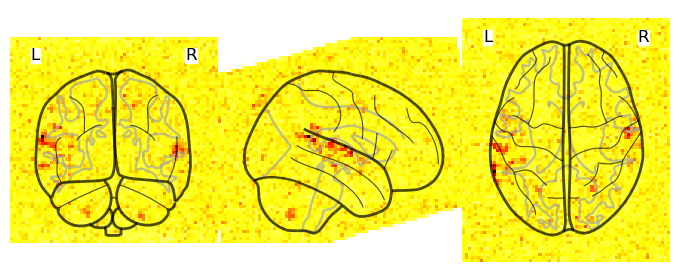

In [68]:
from nilearn import plotting

plotting.plot_glass_brain(ni_img, threshold=1)

In [ ]:
# Get a cortical mesh
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()

In [ ]:
print(fsaverage['description'])

In [ ]:
# Sample the 3D data around each node of the mesh
from nilearn import surface
texture = surface.vol_to_surf(ni_img, fsaverage.pial_right)

In [ ]:
# plot the result 
from nilearn import plotting

# fig = plotting.plot_surf_stat_map(
#     fsaverage.infl_right, texture, hemi='right',
#     title='Surface right hemisphere', colorbar=True,
#     threshold=0, bg_map=fsaverage.sulc_right,
#     engine='plotly'
# )

fig = plotting.plot_surf_stat_map(fsaverage.pial_left, texture, engine='plotly')
fig.show()

In [ ]:
# plot the result 
from nilearn import plotting

# fig = plotting.plot_surf_stat_map(
#     fsaverage.infl_right, texture, hemi='right',
#     title='Surface right hemisphere', colorbar=True,
#     threshold=0, bg_map=fsaverage.sulc_right,
#     engine='plotly'
# )

fig = plotting.plot_surf_stat_map(fsaverage.pial_left, texture, cmap = 'PRGn', engine='plotly', threshold="90%", title='Left hemisphere')
fig.show()

In [ ]:
fig = plotting.plot_surf_stat_map(fsaverage.pial_right, texture, engine='plotly')
fig.show()

In [ ]:
fig = plotting.plot_surf_stat_map(fsaverage.pial_right, texture, cmap = 'PRGn', engine='plotly', threshold="90%", title='Right hemisphere')
fig.show()